# Analysis of the Impact of Government Measures

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

dates = pd.date_range('20200122','20200407')
xticks = pd.date_range('20200122', '20200407', periods=12)

dates_trim = pd.date_range('20200129', '20200407')
xticks_trim = pd.date_range('20200129', '20200407', periods=12)

future = 15
dates_future = pd.date_range('20200407', '20200422')
xticks_future = pd.date_range('20200129', '20200422', periods=14)

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### load the data

In [3]:
global_df = pd.read_csv("covid_19_data.csv")
con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")

con_series_df = con_series_df[con_series_df['Country/Region'] == 'Canada']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

days = np.array([i for i in range(con_series_values.shape[0])]).reshape(-1, 1)

### split train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(days, con_series_values, test_size=0.05, shuffle=False)

### preprocess

In [5]:
poly = PolynomialFeatures(degree=6)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)

poly_forecast = poly.fit_transform(days)

### Linear Regresssion fitted directly on the array of confirmed cases
#### And then test on the same array of confirmed cases

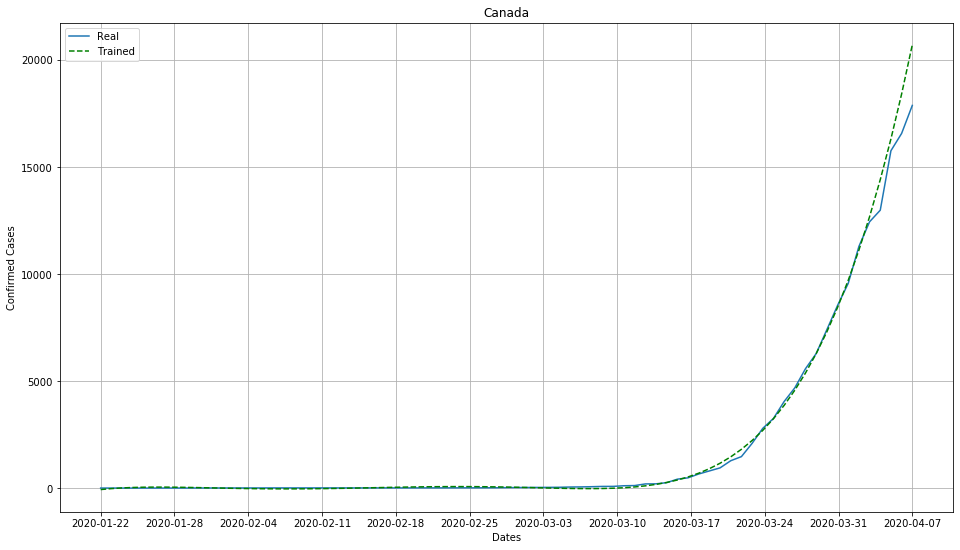

In [6]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
pred = linear_model.predict(poly_forecast)

plt.figure(figsize=(16, 9))
plt.plot(dates, con_series_values, label='Real')
plt.plot(dates, pred, linestyle='dashed', color='green', label='Trained')
plt.grid()
plt.xticks(xticks)
plt.legend()
plt.title('Canada')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

# time series approach
#### transform into a supervised learning with the numbers of the past week to be features

In [7]:
con_series_values = series_to_supervised(con_series_values, 7, 1).values
days = np.array([i for i in range(con_series_values.shape[0])]).reshape(-1, 1)
X = con_series_values[:, :-1]
y = con_series_values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

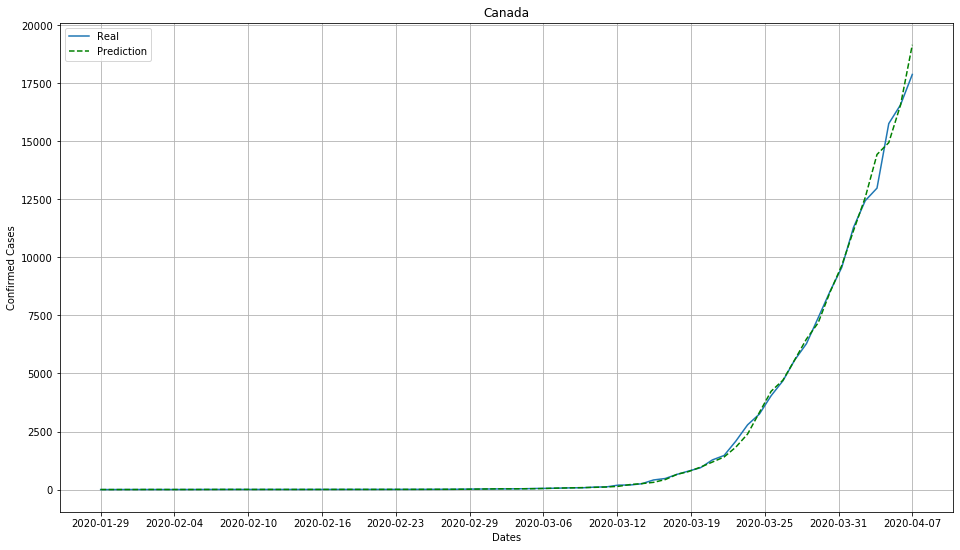

In [8]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)
pred = linear_model.predict(X)

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, y, label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('Canada')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

### policy data

In [9]:
measure = pd.read_csv("covid_19_government.csv")
measure.head()

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
0,163,NaN,Austria,"Mar 16, 2020",NaN,On 10 March 2020 government announced that all...,NaN,NaN,NaN,university closure,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1,132,NaN,Germany,"Feb 01, 2020",NaN,"102 German citizens and 26 relatives, all of w...",NaN,NaN,NaN,"international traveller screening, traveller q...",NaN,https://www.tagesschau.de/inland/coronavirus-g...,NaN,NaN,NaN,NaN
2,578,NaN,United Kingdom,"Mar 20, 2020",NaN,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,"nursery schools closure, school closure, unive...",NaN,https://www.theguardian.com/world/2020/mar/18/...,NaN,NaN,NaN,NaN
3,372,NaN,United Kingdom,"Mar 16, 2020",NaN,If one person in any household has a persisten...,NaN,NaN,NaN,"14 days, contact isolation",NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
4,357,NaN,United Kingdom,"Mar 16, 2020",NaN,"By the weekend, those with the most serious he...",NaN,NaN,NaN,isolation advice to elderly,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN


In [10]:
# helper function for manually setting policy level in excel
def process_measure(measure, country):
    ## First lets drop empty measures
    measure = measure[measure['Description of measure implemented'].notna()]
    measure = measure[measure['Date Start'].notna()]
    measure = measure[measure['Keywords'].notna()]
    measure['Date Start'] = pd.to_datetime(measure['Date Start'])

    measure_value = measure[['Country','Date Start','Keywords']].sort_values('Date Start')
    c = measure_value[measure_value['Country'] == country]
    c = c.reset_index(drop=True)
    c.to_csv("{}_government.csv".format(country), index=False)

### train on Italy with policy inclueded and predict Italy with the same data

In [11]:
italy = pd.read_csv("Italy_government.csv")
italy['Date Start'] = pd.to_datetime(italy['Date Start'])
italy = italy.groupby('Date Start').max().sort_values('Date Start')
italy = italy.reset_index()[['Date Start', 'Level', 'Duration']]

level = italy['Level'].values.reshape(-1, 1)
duration = italy['Duration'].values.reshape(-1,1)

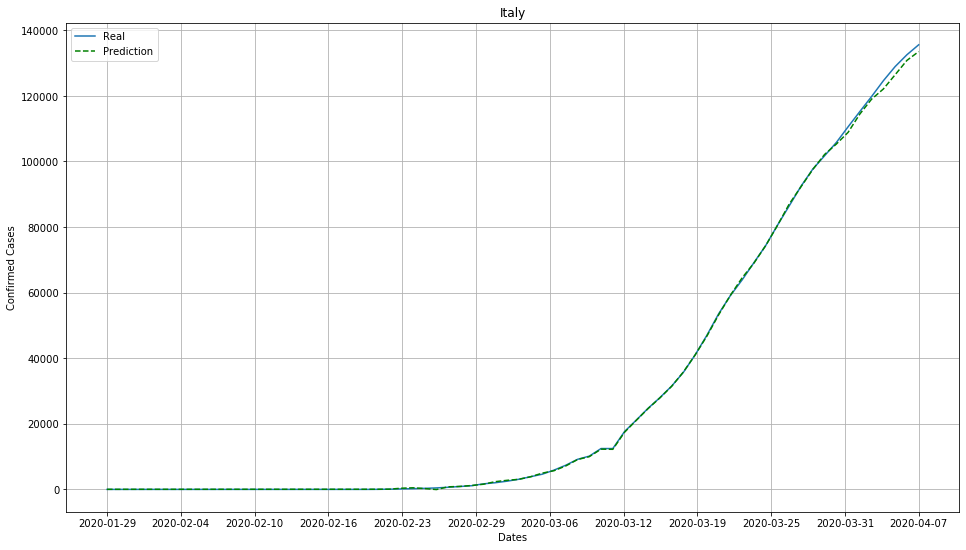

In [12]:
con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Country/Region'] == 'Italy']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

policy = np.append(level, duration, axis=1)
italy_data = series_to_supervised(np.append(policy, con_series_values, axis=1), 7, 1).values
X = italy_data[:, :-1]
y = italy_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)
pred = linear_model.predict(X)

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, y, label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('Italy')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

### predict China with the Italy model above (included policy)

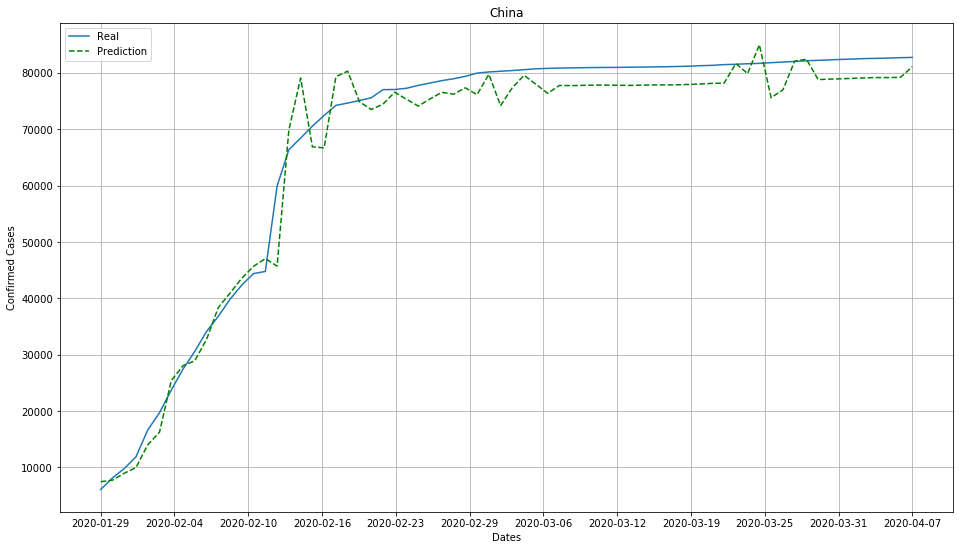

In [13]:
china = pd.read_csv("China_government.csv")

china['Date Start'] = pd.to_datetime(china['Date Start'])
china = china.groupby('Date Start').max().sort_values('Date Start')
china = china.reset_index()[['Date Start', 'Level', 'Duration']]
level = china['Level'].values.reshape(-1, 1)
duration = china['Duration'].values.reshape(-1, 1)

con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Country/Region'] == 'China']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

policy = np.append(level, duration, axis=1)
china_data = series_to_supervised(np.append(policy, con_series_values, axis=1), 7, 1).values
X = china_data[:, :-1]
y = china_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

pred = linear_model.predict(X)

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, y, label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('China')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

### combine italy data and china data and train with policy included, and then predict on the same data of Italy and China

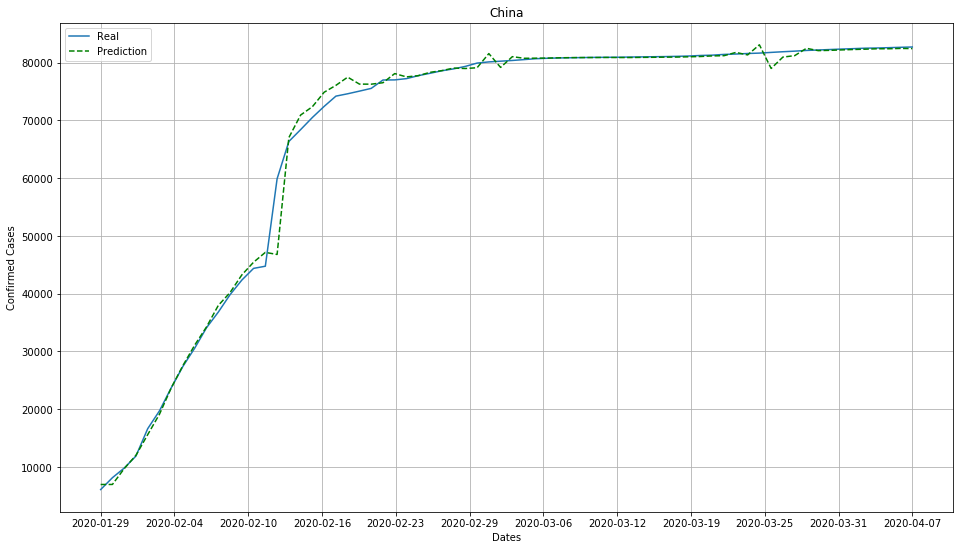

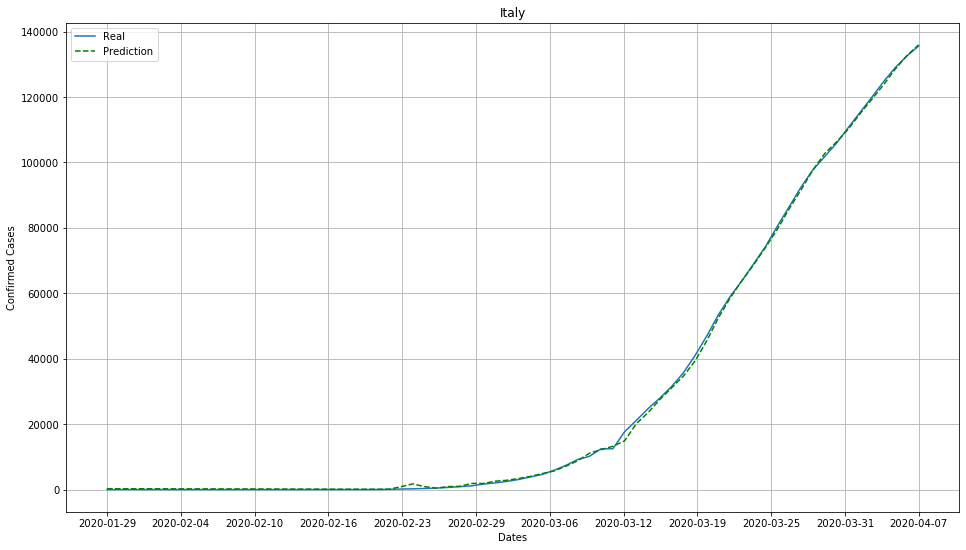

In [14]:
combined_data = np.append(italy_data, china_data, axis=0)
X = combined_data[:, :-1]
y = combined_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)

pred = linear_model.predict(china_data[:, :-1])

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, china_data[:, -1], label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('China')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

pred = linear_model.predict(italy_data[:, :-1])

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, italy_data[:, -1], label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('Italy')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

### use above model to predict on United Kingdom with policy included

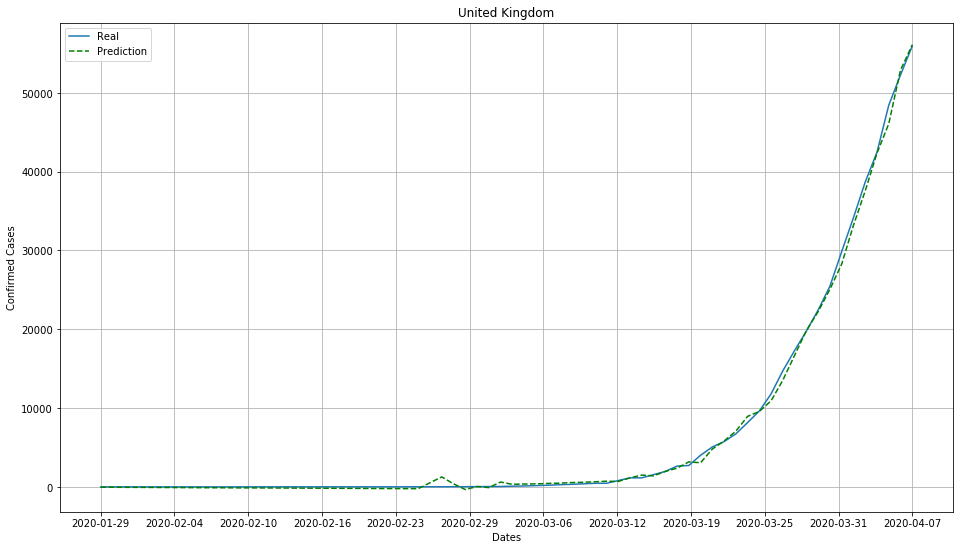

In [15]:
uk = pd.read_csv("United Kingdom_government.csv")

uk['Date Start'] = pd.to_datetime(uk['Date Start'])
uk = uk.groupby('Date Start').max().sort_values('Date Start')
uk = uk.reset_index()[['Date Start', 'Level', 'Duration']]
level = uk['Level'].values.reshape(-1, 1)
duration = uk['Duration'].values.reshape(-1,1)

con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Country/Region'] == 'United Kingdom']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

policy = np.append(level, duration, axis=1)
uk_data = series_to_supervised(np.append(policy, con_series_values, axis=1), 7, 1).values

pred = linear_model.predict(uk_data[:, :-1])

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, uk_data[:, -1], label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('United Kingdom')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

### train on UK, China, Italy data with policy included and then predict on Canada

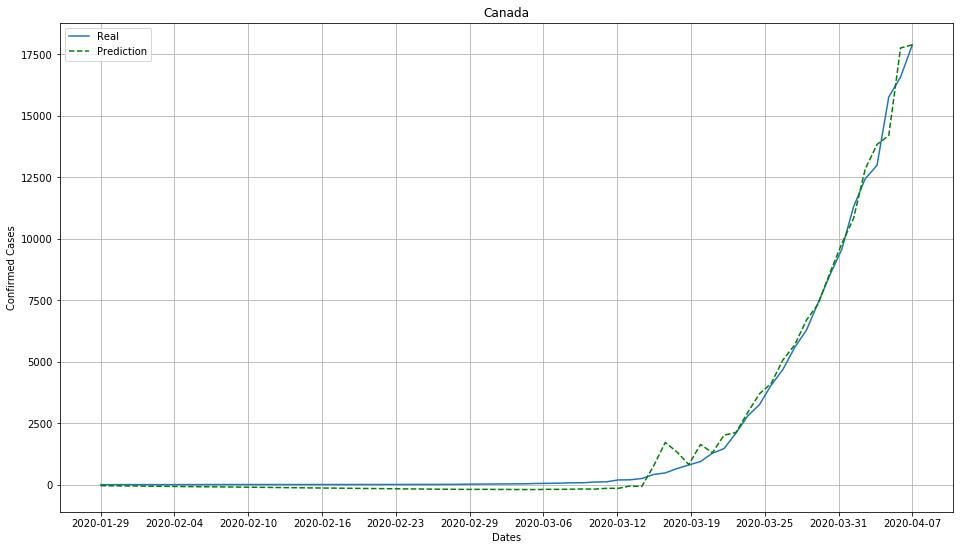

In [16]:
combined_data = np.append(combined_data, uk_data, axis=0)
X = combined_data[:, :-1]
y = combined_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)

canada = pd.read_csv("Canada_government.csv")

canada['Date Start'] = pd.to_datetime(canada['Date Start'])
canada = canada.groupby('Date Start').max().sort_values('Date Start')
canada = canada.reset_index()[['Date Start', 'National', 'National Duration']]
level = canada['National'].values.reshape(-1, 1)
duration = canada['National Duration'].values.reshape(-1, 1)

con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Country/Region'] == 'Canada']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

policy = np.append(level, duration, axis=1)
canada_data = series_to_supervised(np.append(policy, con_series_values, axis=1), 7, 1).values

pred = linear_model.predict(canada_data[:, :-1])

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, canada_data[:, -1], label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.grid()
plt.xticks(xticks_trim)
plt.legend()
plt.title('Canada')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

### prediction on future dates on Canada

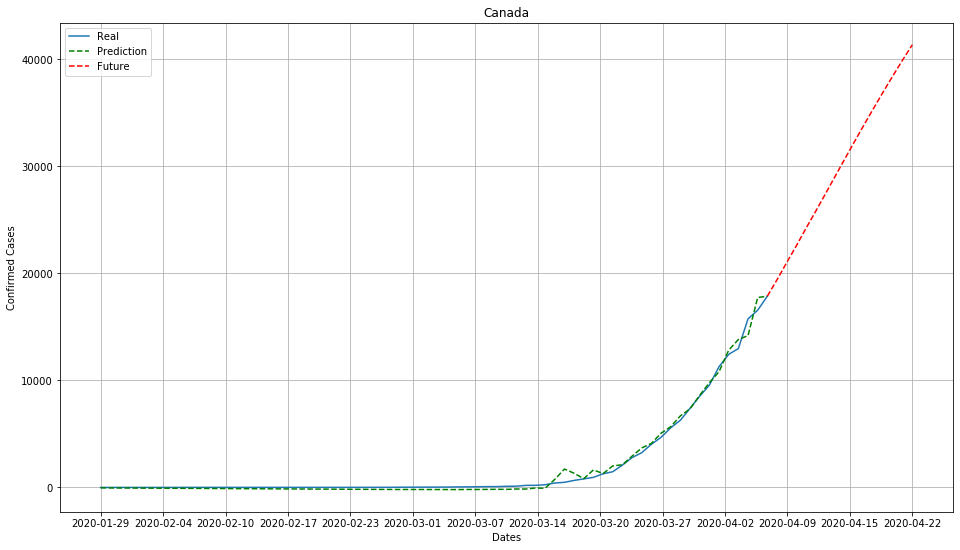

[ 2.22844864e+01  2.65155209e+00 -7.13927990e-02  7.54768182e+01
 -5.71937635e+00 -1.69906040e-02 -7.60499258e+01  1.40571198e+00
 -5.46560498e-02 -3.42718166e+02 -4.98816880e+00  9.63017722e-03
  7.67472336e+02  8.68017086e+00  5.03920864e-02 -1.03362721e+03
  3.57451799e-01 -2.93558984e-01  6.35157720e+02  2.13654302e+00
  1.36900165e+00  2.31004879e+02 -9.79992855e+00]


In [24]:
# future date
new_level = level[-7:]
new_duration = duration[-7:]
new_series_values = con_series_values[-7:]

predictions = [pred[-1]]

for _ in range(future):
    new_level = np.concatenate((new_level, [[2]]))
    last_duration = new_duration[-1][0]
    new_duration = np.concatenate((new_duration, [[last_duration+1]]))
    new_series_values = np.concatenate((new_series_values, [[-1]]))

    new_policy = np.append(new_level, new_duration, axis=1)
    new_data = series_to_supervised(np.append(new_policy, new_series_values, axis=1), 7, 1).values
    new_pred = linear_model.predict(new_data[:, :-1])
    
    predictions.append(new_pred[-1])    
    new_series_values[-1][0] = new_pred[-1]

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, canada_data[:, -1], label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.plot(dates_future, predictions, linestyle='dashed', color='red', label='Future')
plt.grid()
plt.xticks(xticks_future)
plt.legend()
plt.title('Canada')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()

print(linear_model.coef_)

### Prediction on British Columbia

In [ ]:
canada = pd.read_csv("Canada_government.csv")

canada['Date Start'] = pd.to_datetime(canada['Date Start'])
canada = canada.groupby('Date Start').max().sort_values('Date Start')
bc = canada.reset_index()[['Date Start', 'BC', 'BC Duration']]
level = bc['BC'].values.reshape(-1, 1)
duration = bc['BC Duration'].values.reshape(-1,1)

con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Province/State'] == 'British Columbia']
con_series_df = con_series_df.groupby(['Province/State']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

policy = np.append(level, duration, axis=1)
bc_data = series_to_supervised(np.append(policy, con_series_values, axis=1), 7, 1).values

pred = linear_model.predict(bc_data[:, :-1])

# future date
new_level = level[-7:]
new_duration = duration[-7:]
new_series_values = con_series_values[-7:]

predictions = [pred[-1]]

for _ in range(future):
    new_level = np.concatenate((new_level, [[2]]))
    last_duration = new_duration[-1][0]
    new_duration = np.concatenate((new_duration, [[last_duration+1]]))
    new_series_values = np.concatenate((new_series_values, [[-1]]))

    new_policy = np.append(new_level, new_duration, axis=1)
    new_data = series_to_supervised(np.append(new_policy, new_series_values, axis=1), 7, 1).values
    new_pred = linear_model.predict(new_data[:, :-1])
    
    predictions.append(new_pred[-1])    
    new_series_values[-1][0] = new_pred[-1]

plt.figure(figsize=(16, 9))
plt.plot(dates_trim, bc_data[:, -1], label='Real')
plt.plot(dates_trim, pred, linestyle='dashed', color='green', label='Prediction')
plt.plot(dates_future, predictions, linestyle='dashed', color='red', label='Future')
plt.grid()
plt.xticks(xticks_future)
plt.legend()
plt.title('Canada')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.show()